### geoid correction using pixc data.
1. centeralization of height_ellipsoid (i.e., spatial heterogeneity of height_ellipsoid);   
2. covert multitemporal pixc-based spatial heterogeneity of height to raster data
3. temporal smoothing for spatial heterogeneity of height_ellipsoid.


In [3]:
import xarray as xr
import numpy as np
from glob import glob
import geopandas as gpd
import matplotlib.pyplot as plt
from utils.pixc2raster import pixc2raster
from utils.functions import meter2deg


In [17]:
path_lake_vec = 'data/chaohu-lake/hydrolake_chaohu.gpkg'
dir_pixc = 'data/chaohu-lake/swot-pixc'
paths_pixc_filtered = sorted(glob(dir_pixc + '/*masked_filtered.nc'))  # Get the first .nc file in the directory
print(len(paths_pixc_filtered))
paths_pixc_filtered[0]


9


'data/chaohu-lake/swot-pixc/SWOT_L2_HR_PIXC_009_187_210L_20240110T193829_20240110T193840_PIC0_01_masked_filtered.nc'

In [18]:
## 1. read vector file of the lake.
lake_gdf = gpd.read_file(path_lake_vec)


### 1. calculate the spatial heterogeneity of height for pixc data

In [ ]:
## calculate the corrected geoid 
pixcs_geoid_cor_ds = []
for path in paths_pixc_filtered:
    pixc_filtered_nc = xr.open_dataset(path)
    pixc_geoid_cor_ds = pixc_filtered_nc[['geoid', 'ht_valid_ids']]
    ## calculate corrected geoid
    pixc_ht_ellip = pixc_filtered_nc['ht_ortho_filter2'].values + pixc_filtered_nc['geoid'].values
    pixc_ht_ellip_spavar = pixc_ht_ellip - np.nanmean(pixc_ht_ellip) ## i.e., spatial variance of height anomalies
    geoid_mean = np.nanmean(pixc_filtered_nc['geoid'])
    pixc_geoid_cor = geoid_mean + pixc_ht_ellip_spavar    ## Pixc Geoid correction
    ## save as DataArray
    pixc_geoid_cor_ds = pixc_geoid_cor_ds.assign({'geoid_cor': (("points",), pixc_geoid_cor)})
    pixc_geoid_cor_ds = pixc_geoid_cor_ds.assign({'ht_ellip_spahet': (("points",), pixc_ht_ellip_spavar)})
    pixc_geoid_cor_ds['geoid_cor'].attrs['description'] = 'corrected geoid of PIXC points'
    pixc_geoid_cor_ds['ht_ellip_spahet'].attrs['description'] = 'spatial heterogeneity of height anomalies of the lake'
    pixcs_geoid_cor_ds.append(pixc_geoid_cor_ds)



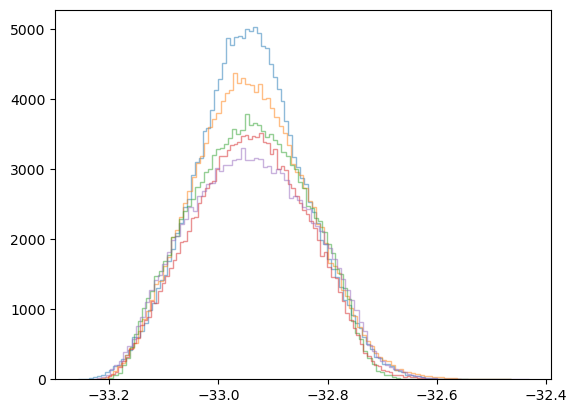

In [14]:
plt.hist(pixcs_geoid_cor_ds[0]['geoid_cor'].values, bins=100, alpha=0.5, histtype='step');
plt.hist(pixcs_geoid_cor_ds[1]['geoid_cor'].values, bins=100, alpha=0.5, histtype='step');
plt.hist(pixcs_geoid_cor_ds[2]['geoid_cor'].values, bins=100, alpha=0.5, histtype='step');
plt.hist(pixcs_geoid_cor_ds[3]['geoid_cor'].values, bins=100, alpha=0.5, histtype='step');
plt.hist(pixcs_geoid_cor_ds[4]['geoid_cor'].values, bins=100, alpha=0.5, histtype='step');



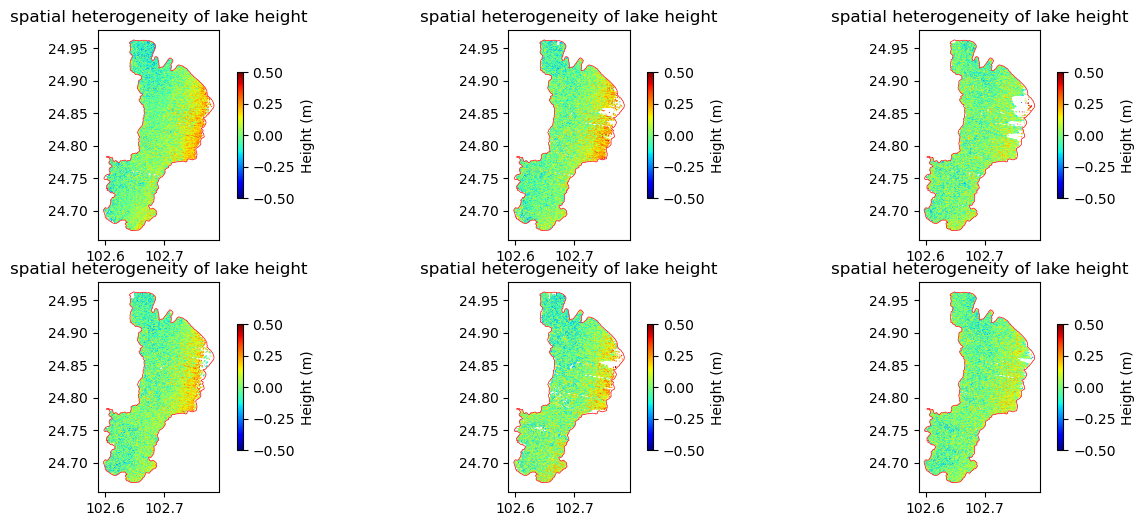

In [43]:
fig, ax = plt.subplots(2, 3, figsize=(15, 6))
for i in range(2):
  for j in range(3):
    idx = i*3 + j
    if idx >= len(pixcs_geoid_cor_ds): break
    scat = ax[i][j].scatter(x=pixcs_geoid_cor_ds[idx].longitude, y=pixcs_geoid_cor_ds[idx].latitude, 
                          c=pixcs_geoid_cor_ds[idx]['ht_ellip_spahet'].values,
                          s=0.5, edgecolor='none', cmap='jet',
                          vmin=-0.5, vmax=0.5
                          )
    lake_gdf.plot(ax=ax[i][j], color='none', edgecolor='red', linewidth=0.5)
    plt.colorbar(scat, label='Height (m)', shrink=0.6) 
    ax[i][j].set_title('spatial heterogeneity of lake height')


### 2. covert multitemporal pixc-based spatial heterogeneity of height to raster data

In [44]:
xmin, ymin, xmax, ymax = lake_gdf.geometry[0].buffer(0.01).bounds
raster_extent = (xmin, xmax, ymin, ymax)
print('raster extent:', raster_extent)
lat_center = pixcs_geoid_cor_ds[0]['geoid'].latitude.mean().values
res_lon, res_lat = meter2deg(meter=500, lat=lat_center)
print('resolution (lon, lat):', res_lon, res_lat)


raster extent: (102.58735478065672, 102.7945962055395, 24.659172532594734, 24.973034361471274)
resolution (lon, lat): 0.004954630916352523 0.004496608029593653


In [58]:
## convert pixc data to raster
# for geoid_cor (multitemporal data)
rasters_ht_spahet = []
for pixc_geoid_cor in pixcs_geoid_cor_ds:
    raster_geoid_cor = pixc2raster(pixc_var = pixc_geoid_cor['ht_ellip_spahet'], 
                          raster_extent=raster_extent,
                          pixc_lonlat=(pixc_geoid_cor.longitude.values, pixc_geoid_cor.latitude.values), 
                          resolution=(res_lon, res_lat))
    raster_geoid_cor.attrs = pixc_geoid_cor.attrs
    rasters_ht_spahet.append(raster_geoid_cor)

## for geoid
raster_geoid = pixc2raster(pixc_var = pixc_geoid_cor['geoid'], 
                      raster_extent=raster_extent,
                      pixc_lonlat=(pixc_geoid_cor['geoid'].longitude.values, pixc_geoid_cor['geoid'].latitude.values), 
                      resolution=(res_lon, res_lat))
# for geoid_spahet
raster_geoid_spahet = pixc2raster(pixc_var = pixc_geoid_cor['geoid']-np.nanmean(pixc_geoid_cor['geoid']), 
                      raster_extent=raster_extent,
                      pixc_lonlat=(pixc_geoid_cor['geoid'].longitude.values, pixc_geoid_cor['geoid'].latitude.values), 
                      resolution=(res_lon, res_lat))

raster_geoid
rasters_ht_spahet[0]


<xarray.DataArray (y: 70, x: 42)> Size: 24kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * x        (x) float64 336B 102.6 102.6 102.6 102.6 ... 102.8 102.8 102.8
  * y        (y) float64 560B 24.97 24.97 24.96 24.96 ... 24.67 24.66 24.66
Attributes:
    date:     2024-01-05

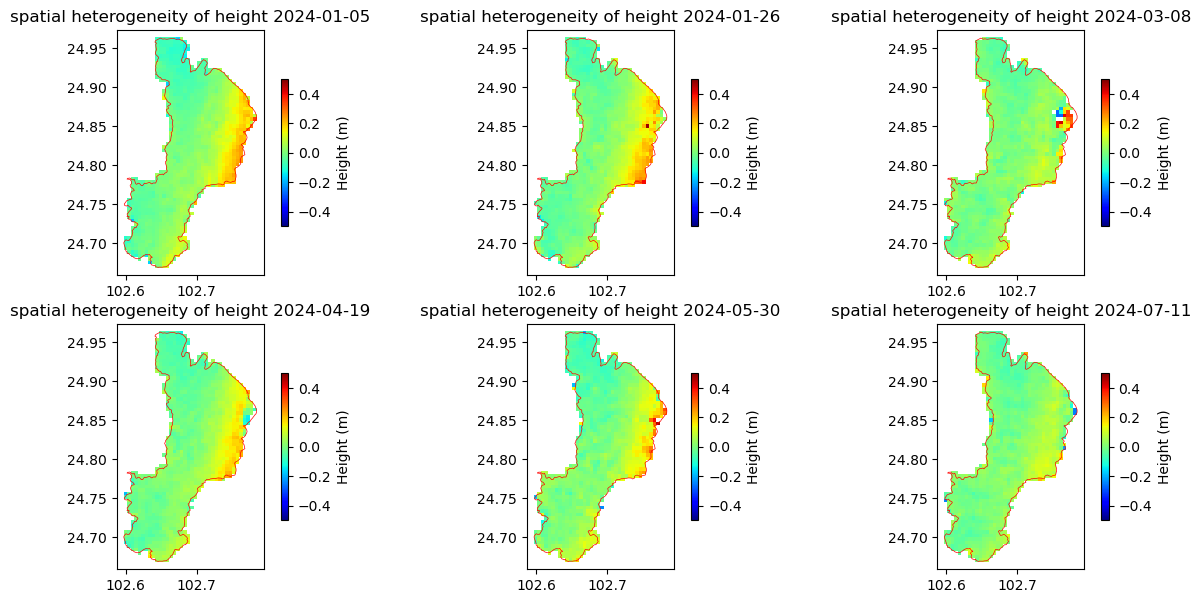

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(15, 7))
range_color = 1
for i in range(2):
  for j in range(3):
    idx = i * 3 + j
    if idx >= len(rasters_ht_spahet): break
    im_show = ax[i][j].imshow(rasters_ht_spahet[idx], cmap='jet', 
                              extent=raster_extent,vmin=-0.5, vmax=0.5)
    lake_gdf.plot(ax=ax[i][j], color='none', edgecolor='red', linewidth=0.5)
    plt.colorbar(im_show, label='Height (m)', shrink=0.6)
    ax[i][j].set_title('spatial heterogeneity of height ' + rasters_ht_spahet[idx].date)


### 3. perform temporal smoothing for the spatial heterogeneity of height.

In [56]:
## temporal smoothing using median filter
rasters_ht_spahet_da = xr.concat(rasters_ht_spahet, dim='date') 
raster_ht_spahet_smooth = rasters_ht_spahet_da.median(dim='date', keep_attrs=True)  # temporal smoothing
raster_ht_spahet_smooth.name = "height_spahet_smoothed"
raster_ht_spahet_smooth


<xarray.DataArray 'height_spahet_smoothed' (y: 70, x: 42)> Size: 24kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * x        (x) float64 336B 102.6 102.6 102.6 102.6 ... 102.8 102.8 102.8
  * y        (y) float64 560B 24.97 24.97 24.96 24.96 ... 24.67 24.66 24.66
Attributes:
    date:     2024-01-05

In [69]:
raster_geoid_spahet.attrs['description'] = 'the original spatial heterogeneity of height anomalies of the lake, '
raster_ht_spahet_smooth.attrs['description'] = 'the swot data-derived spatial heterogeneity of height anomalies of the lake'
raster_height_spahet_ds = xr.Dataset({
    'geoid': raster_geoid.rename('geoid'),
    'geoid_spahet': raster_geoid_spahet.rename('geoid_spahet'),
    'ht_spahet_smoothed': raster_ht_spahet_smooth.rename('ht_spahet_smoothed')
})
raster_height_spahet_ds
# Save as NetCDF file
path_raster_height_spahet = dir_pixc + '/raster_height_spahet.nc'
raster_height_spahet_ds.to_netcdf(path_raster_height_spahet)


<xarray.Dataset> Size: 71kB
Dimensions:             (x: 42, y: 70)
Coordinates:
  * x                   (x) float64 336B 102.6 102.6 102.6 ... 102.8 102.8 102.8
  * y                   (y) float64 560B 24.97 24.97 24.96 ... 24.67 24.66 24.66
Data variables:
    geoid               (y, x) float64 24kB nan nan nan nan ... nan nan nan nan
    geoid_spahet        (y, x) float64 24kB nan nan nan nan ... nan nan nan nan
    ht_spahet_smoothed  (y, x) float64 24kB nan nan nan nan ... nan nan nan nan

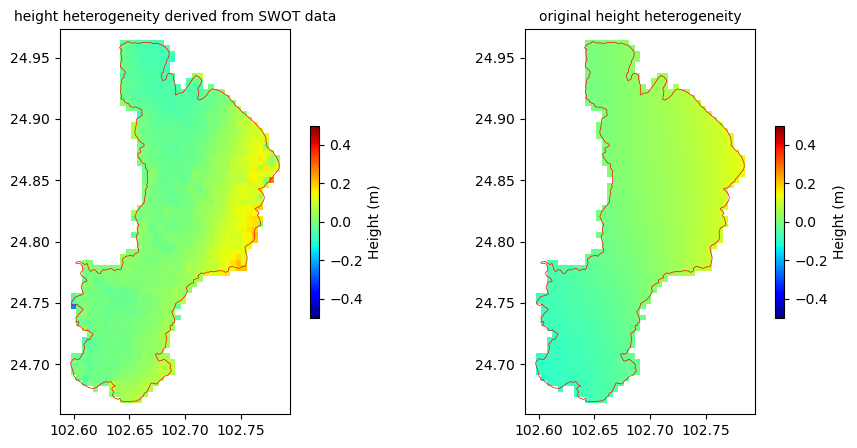

In [70]:
fig, ax = plt.subplots(1,2,figsize=(11, 5))
## ax1
scat1 = ax[0].imshow(raster_height_spahet_ds['ht_spahet_smoothed'], cmap='jet', extent=raster_extent,
             vmin=-0.5, vmax=+0.5
             )
lake_gdf.plot(ax=ax[0], color='none', edgecolor='red', linewidth=0.5)
ax[0].set_title('height heterogeneity derived from SWOT data', fontsize=10)
plt.colorbar(scat1, ax=ax[0], label='Height (m)', shrink=0.5)
# ax2
scat2 = ax[1].imshow(raster_height_spahet_ds['geoid_spahet'], cmap='jet', extent=raster_extent,
             vmin=-0.5, vmax=+0.5
             )
lake_gdf.plot(ax=ax[1], color='none', edgecolor='red', linewidth=0.5)
ax[1].set_title('original height heterogeneity', fontsize=10)
plt.colorbar(scat2, ax=ax[1], label='Height (m)', shrink=0.5)


: 